In [30]:
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import IPython.display as ipd
import wget
import seaborn as sns
import zipfile
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.nn import TransformerConv
import polars as pl
import IPython.display as ipd
import soundfile as sf
from tqdm import tqdm
from prettytable import PrettyTable
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
# from torch.utils.data import DataLoader, TensorDataset

In [2]:
dir_path = "/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset"
dataset_path = os.path.join(dir_path, "fma_small")
metadata_path = os.path.join(dir_path, "fma_metadata")

In [7]:
tracks = pd.read_csv(os.path.join(metadata_path, "tracks.csv"), index_col=0, header=[0, 1])
genres = pd.read_csv(os.path.join(metadata_path, "genres.csv"), index_col=0, header=[0, 1])
features = pd.read_csv(os.path.join(metadata_path, "features.csv"), index_col=0, header=[0, 1])
echonest = pd.read_csv(os.path.join(metadata_path, "echonest.csv"), index_col=0, header=[0, 1])

# print the shape of the dataframes
print(f'tracks shape = {tracks.shape}')
print(f'genres shape = {genres.shape}')
print(f'features shape = {features.shape}')
print(f'echonest shape = {echonest.shape}')

trackid_list = tracks.index.tolist()
all_dfs_name = {}
for col in tracks.columns:
    df_name = col[0]
    df_col_name = col[1]
    if df_name not in all_dfs_name:
        all_dfs_name[df_name] = {}
    all_dfs_name[df_name][df_col_name] = tracks[col].values

print(all_dfs_name.keys())

for k, v in all_dfs_name.items():
    df_name = f'{k}_df'
    globals()[df_name] = pd.DataFrame(v)

print(album_df.columns)
print(artist_df.columns)
print(set_df.columns)
print(track_df.columns)

intermediate_df = track_df[['title', 'duration', 'genre_top']]
intermediate_df['track_id'] = trackid_list
intermediate_df = intermediate_df.dropna()
print(intermediate_df.shape)
intermediate_df.info()

/tmp/ipykernel_6982/1610969008.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv(os.path.join(metadata_path, "features.csv"), index_col=0, header=[0, 1])


tracks shape = (106574, 52)
genres shape = (162, 4)
features shape = (106576, 518)
echonest shape = (13131, 249)
dict_keys(['album', 'artist', 'set', 'track'])
Index(['comments', 'date_created', 'date_released', 'engineer', 'favorites',
       'id', 'information', 'listens', 'producer', 'tags', 'title', 'tracks',
       'type'],
      dtype='object')
Index(['active_year_begin', 'active_year_end', 'associated_labels', 'bio',
       'comments', 'date_created', 'favorites', 'id', 'latitude', 'location',
       'longitude', 'members', 'name', 'related_projects', 'tags', 'website',
       'wikipedia_page'],
      dtype='object')
Index(['split', 'subset'], dtype='object')
Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')
(49597, 4)
<class 'pandas

/tmp/ipykernel_6982/1610969008.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  echonest = pd.read_csv(os.path.join(metadata_path, "echonest.csv"), index_col=0, header=[0, 1])
/tmp/ipykernel_6982/1610969008.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intermediate_df['track_id'] = trackid_list


In [10]:
os.makedirs(os.path.join(dir_path, 'fma_small_songs'), exist_ok=True)
song_files = glob.glob(os.path.join(dataset_path, '**/*.mp3'), recursive=True)
for song_file in song_files:
    os.rename(song_file, os.path.join(dir_path, 'fma_small_songs', os.path.basename(song_file)))

folders = glob.glob(os.path.join(dataset_path, '**/'), recursive=True)
print(folders)
for folder in folders[1:]:
    os.rmdir(folder)

['/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small/']


In [11]:
new_dir_path = os.path.join(dir_path, 'fma_small_songs')
intermediate_df['track_id'] = intermediate_df['track_id'].apply(lambda x: str(x).zfill(6))
song_files_paths = glob.glob(os.path.join(new_dir_path, '**/*.mp3'), recursive=True)
print(len(song_files_paths))

for f in song_files_paths:
    track_id = os.path.basename(f).split('.')[0]
    if track_id in intermediate_df['track_id'].values:
        intermediate_df.loc[intermediate_df['track_id'] == track_id, 'file_path'] = f
intermediate_df.dropna(inplace=True)
print(intermediate_df.shape)
new_dir_path_5s = os.path.join(dir_path, 'fma_small_5s')
os.makedirs(new_dir_path_5s, exist_ok=True)


8000
(8000, 5)


In [12]:
# for i in song_files_paths:
#     try:
#         x, fs = librosa.load(i)
#         duration = len(x)
#         greater_than_5s = fs * 5
#         if len(x) > greater_than_5s:
#             start = np.random.randint(0, len(x) - greater_than_5s)
#             x_5s = x[start:start + greater_than_5s]
#             new_fn = os.path.join(new_dir_path_5s, os.path.basename(i))
#             sf.write(new_fn, x_5s, fs)
#     except Exception as e:
#         print(i, e)

intermediate_df['file_path_5s'] = intermediate_df['file_path'].apply(lambda x: x.replace('fma_small_songs', 'fma_small_5s'))
print(intermediate_df['file_path_5s'].shape)


(8000,)


In [13]:
# check what tracks are missing from the 5s dataset and delete it from the dataframe as well
five_s_song_files_paths = glob.glob(os.path.join(new_dir_path_5s, '**/*.mp3'), recursive=True)
print(len(five_s_song_files_paths))
missing_tracks = []
for i in intermediate_df['file_path_5s']:
    if i not in five_s_song_files_paths:
        missing_tracks.append(i)
print(missing_tracks)
intermediate_df = intermediate_df[~intermediate_df['file_path_5s'].isin(missing_tracks)]
print(intermediate_df.shape)
intermediate_df.to_csv('intermediate_df.csv', index=False)
intermediate_df.head()


7994
['/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/098565.mp3', '/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/098567.mp3', '/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/098569.mp3', '/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/099134.mp3', '/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/108925.mp3', '/home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/133297.mp3']
(7994, 6)


title  duration genre_top track_id  \
0                 Food       168   Hip-Hop   000002   
2           This World       206   Hip-Hop   000005   
3              Freeway       161       Pop   000010   
15  Queen Of The Wires       253      Folk   000140   
16                Ohio       182      Folk   000141   

                                            file_path  \
0   /home/ics/Documents/Education/Media_engg/Sem_1...   
2   /home/ics/Documents/Education/Media_engg/Sem_1...   
3   /home/ics/Documents/Education/Media_engg/Sem_1...   
15  /home/ics/Documents/Education/Media_engg/Sem_1...   
16  /home/ics/Documents/Education/Media_engg/Sem_1...   

                                         file_path_5s  
0   /home/ics/Documents/Education/Media_engg/Sem_1...  
2   /home/ics/Documents/Education/Media_engg/Sem_1...  
3   /home/ics/Documents/Education/Media_engg/Sem_1...  
15  /home/ics/Documents/Education/Media_engg/Sem_1...  
16  /home/ics/Documents/Education/Media_engg/Sem_1...

In [14]:
intermediate_df['file_path_5s']

0         /home/ics/Documents/Education/Media_engg/Sem_1...
2         /home/ics/Documents/Education/Media_engg/Sem_1...
3         /home/ics/Documents/Education/Media_engg/Sem_1...
15        /home/ics/Documents/Education/Media_engg/Sem_1...
16        /home/ics/Documents/Education/Media_engg/Sem_1...
                                ...                        
105713    /home/ics/Documents/Education/Media_engg/Sem_1...
105714    /home/ics/Documents/Education/Media_engg/Sem_1...
105815    /home/ics/Documents/Education/Media_engg/Sem_1...
105816    /home/ics/Documents/Education/Media_engg/Sem_1...
106385    /home/ics/Documents/Education/Media_engg/Sem_1...
Name: file_path_5s, Length: 7994, dtype: object

In [15]:
def compute_mff_for_dataset(df, emb_dim):
    mfccs = []
    file_paths = df['file_path_5s'].values
    for f in tqdm(file_paths):
        y, sr = librosa.load(f, sr=None)
        mfcc_unnorm = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=emb_dim)
        mfcc_mean = np.mean(mfcc_unnorm, axis=1)
        mfccs.append(mfcc_mean)
    mfcc_array = np.array(mfccs)
    return mfcc_array

mfcc = compute_mff_for_dataset(intermediate_df, 30)
print(mfcc.shape)
print("Feature extraction finished")

np.save("mfcc_embeddings_fma_5s.npy", mfcc)

100%|██████████| 7994/7994 [05:21<00:00, 24.84it/s]

(7994, 30)
Feature extraction finished


In [8]:
# G = nx.Graph()
# G.add_nodes_from(intermediate_df["track_id"])
# pos = nx.circular_layout(G)

# for i, row1 in tqdm(intermediate_df.iterrows()):
#     for j, row2 in intermediate_df.iterrows():
#         if row1["track_id"] != row2["track_id"] and row1["genre_top"] == row2["genre_top"]:
#             G.add_edge(row1["track_id"], row2["track_id"])

# nx.write_gml(G, "graph.gml")
# nx.write_pajek(G, "graph.net")
# nx.write_edgelist(G, "graph.edgelist")
# nx.write_adjlist(G, "graph.adjlist")

In [9]:
# how to load various format types
# G = nx.read_gml("graph.gml")
# G = nx.read_pajek("graph.net")
# G = nx.read_edgelist("graph.edgelist")
# G = nx.read_adjlist("graph.adjlist")

In [4]:
G = nx.read_gml("graph.gml")
intermediate_df = pd.read_csv('intermediate_df.csv')
labels = LabelEncoder().fit_transform(intermediate_df["genre_top"])
labels_tensor = torch.tensor(labels, dtype=torch.long)
unique_genres = sorted(list(set(intermediate_df["genre_top"])))
n_genres = len(unique_genres)
genre_to_id = {unique_genres[_]: _ for _ in range(n_genres)}
id_to_genre = {_: unique_genres[_] for _ in range(n_genres)}
print(id_to_genre)
print(genre_to_id)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}
{'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3, 'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}


In [63]:
songs_for_inference = {}
for id, genre in id_to_genre.items():
    genre_df = intermediate_df[intermediate_df['genre_top'] == genre]
    genre_indices = genre_df.sample(n=100, random_state=1).index.tolist()
    songs_for_inference[genre] = genre_indices

print(songs_for_inference)

{'Electronic': [62182, 70509, 58426, 49213, 37141, 95983, 42442, 84023, 47039, 15860, 58041, 26674, 67190, 47848, 95908, 25444, 21059, 3647, 69142, 61564, 75140, 59783, 69135, 61990, 57330, 23301, 21181, 68187, 90383, 49289, 94690, 83371, 77295, 61562, 51919, 43965, 18101, 76114, 71454, 70514, 75896, 84458, 19259, 20514, 19570, 67053, 65267, 14271, 58427, 79459, 81462, 13021, 70259, 13209, 27902, 58429, 91245, 74676, 61114, 75643, 46712, 37017, 50135, 77001, 71296, 66823, 59453, 84174, 63158, 7950, 75899, 49215, 37136, 98796, 58431, 16676, 32012, 85456, 47052, 97082, 37670, 77090, 77987, 77988, 97080, 69143, 59368, 67041, 85926, 63066, 96948, 31993, 62541, 97872, 54402, 75973, 66172, 68923, 38197, 29847], 'Experimental': [49805, 59202, 43818, 33601, 25502, 89867, 27701, 80038, 30689, 3882, 43812, 16980, 56919, 32276, 89174, 15664, 11049, 746, 58654, 47450, 71833, 46617, 58650, 49053, 43166, 15038, 11642, 56998, 85265, 33740, 86983, 79646, 77338, 47448, 38258, 28895, 6071, 74593, 65149,

In [26]:
for k, v in songs_for_inference.items():
    print(k, len(v))

Electronic 100
Experimental 100
Folk 100
Hip-Hop 100
Instrumental 100
International 100
Pop 100
Rock 100


[71405, 83041, 44560, 94187, 85328, 16674, 54170, 91245, 20749, 50869, 50920, 28804, 6719, 75973, 60087, 43584, 25048, 19030, 86621, 72631]


20it [00:00, 1735.84it/s]

[('108461', '123509'), ('108461', '065755'), ('123509', '065755'), ('138015', '074445'), ('138015', '012058'), ('138015', '088874'), ('138015', '064553'), ('126587', '080520'), ('126587', '030196'), ('026904', '134052'), ('026904', '114388'), ('080520', '030196'), ('134052', '114388'), ('032693', '128443'), ('074445', '012058'), ('074445', '088874'), ('074445', '064553'), ('043598', '038775'), ('012058', '088874'), ('012058', '064553'), ('088874', '064553')]


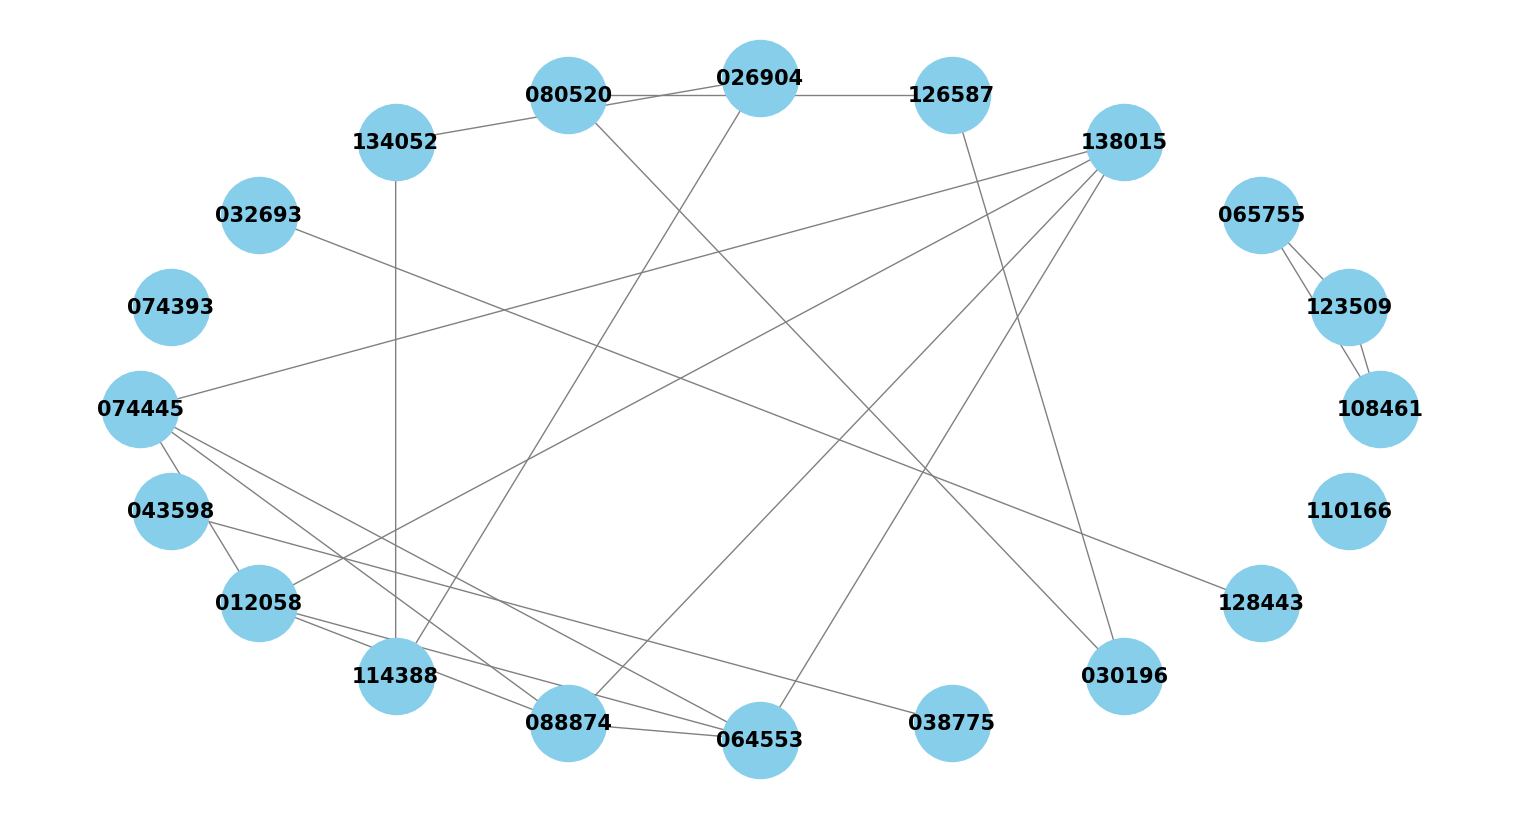

In [40]:
# choose random 12 points from the intermediate_df

sage_embeddings = np.load('mfcc_sage_embeddings_fma_5s.npy')
gcn_embeddings = np.load('mfcc_gcn_embeddings_fma_5s.npy')
mfcc_embeddings = np.load('mfcc_embeddings_fma_5s.npy')

random_indices = intermediate_df.sample(n=20, random_state=1).index.tolist()
print(random_indices)

for_representation_df = intermediate_df.loc[random_indices]
H = nx.Graph()
H.add_nodes_from(for_representation_df["track_id"])
pos = nx.circular_layout(H)

for i, row1 in tqdm(for_representation_df.iterrows()):
    for j, row2 in for_representation_df.iterrows():
        if row1["track_id"] != row2["track_id"] and row1["genre_top"] == row2["genre_top"]:
            H.add_edge(row1["track_id"], row2["track_id"])

print(H.edges())

plt.figure(figsize=(15, 8))
nx.draw(
    H,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="skyblue",
    font_size=15,
    font_weight="bold",
    edge_color="gray",
)

In [35]:

node_to_index = {node: index for index, node in enumerate(G.nodes)}
edge_index = (
    torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in G.edges])
    .t()
    .contiguous()
)
data = Data(edge_index=edge_index)
data.x = torch.tensor(mfcc_embeddings, dtype=torch.float32)
data_loader = DataLoader([data], batch_size=16, shuffle=True)

In [94]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, out_channels)
        self.conv2 = SAGEConv(out_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x


model = GraphSAGE(in_channels=30, out_channels=30)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

# losses = []
# for epoch in range(50):
#     model.train()
#     epoch_loss = 0
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     epoch_loss /= len(data_loader)
#     losses.append(epoch_loss)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# plt.plot(range(1, len(losses)+1), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Graph SAGE Train Loss (vs) Epochs')
# plt.legend()
# plt.grid(True)
# plt.savefig('GraphSAGE_loss_plot.png')
# plt.show()

# model.eval()
# with torch.no_grad():
#     sage_embeddings = model(data).detach().numpy()

# np.save("mfcc_sage_embeddings_fma_5s.npy", sage_embeddings)
# print(sage_embeddings.shape)

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| conv1.lin_l.weight |    900     |
|  conv1.lin_l.bias  |     30     |
| conv1.lin_r.weight |    900     |
| conv2.lin_l.weight |    900     |
|  conv2.lin_l.bias  |     30     |
| conv2.lin_r.weight |    900     |
+--------------------+------------+
Total Trainable Params: 3660


3660

In [96]:
1860 + 8360

10220

In [93]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


model = GCN(in_channels=30, out_channels=30)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

# losses = []
# for epoch in range(50):
#     model.train()
#     epoch_loss = 0
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()
#     epoch_loss /= len(data_loader)
#     losses.append(epoch_loss)
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# plt.plot(range(1, len(losses)+1), losses, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('GCN Train Loss (vs) Epochs')
# plt.legend()
# plt.grid(True)
# plt.savefig('GCN_loss_plot.png')
# plt.show()

# model.eval()
# with torch.no_grad():
#     gcn_embeddings = model(data).detach().numpy()

# np.save("mfcc_gcn_embeddings_fma_5s.npy", gcn_embeddings)
# print(gcn_embeddings.shape)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |     30     |
| conv1.lin.weight |    900     |
|    conv2.bias    |     30     |
| conv2.lin.weight |    900     |
+------------------+------------+
Total Trainable Params: 1860


1860

In [43]:
# class GraphTransformer(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(GraphTransformer, self).__init__()
#         self.conv1 = TransformerConv(in_channels, out_channels, heads=4, concat=True)
#         self.conv2 = TransformerConv(
#             out_channels * 4, out_channels, heads=4, concat=False
#         )

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv2(x, edge_index)
#         return x


# model = GraphTransformer(in_channels=100, out_channels=100)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# print(model)

# for epoch in range(50):
#     model.train()
#     optimizer.zero_grad()
#     for data in data_loader:
#         out = model(data)
#         loss = criterion(out, labels_tensor)
#         loss.backward()
#         optimizer.step()
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# model.eval()
# with torch.no_grad():
#     transformer_embeddings = model(data).detach().numpy()

# np.save("mfcc_gt_embeddings_fma_5s.npy", transformer_embeddings)
# print(transformer_embeddings.shape)

In [44]:
from torch.utils.data import DataLoader, TensorDataset

class SimpleMLP(nn.Module):
    def __init__(self, n_in, n_classes=n_genres):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(n_in, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, n_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x), dim=1)
        return x


<class 'torch.Tensor'> torch.Size([6395, 30]) <class 'torch.Tensor'> torch.Size([1599, 30]) torch.Size([6395]) torch.Size([1599])
Epoch 1, Loss: 1.984326758980751
Epoch 11, Loss: 1.857611356675625
Epoch 21, Loss: 1.836353018283844
Epoch 31, Loss: 1.8245543044805528
Epoch 41, Loss: 1.8086411529779434


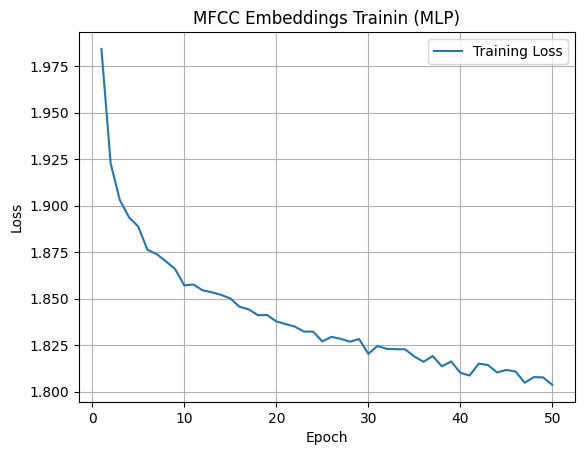

Accuracy: 42.65165728580363%
{'Electronic': [62182, ['Pop', 'Hip-Hop', 'Electronic', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'Instrumental', 'Electronic'], 70509, ['Hip-Hop', 'International', 'Electronic', 'Hip-Hop', 'Pop', 'International', 'Electronic', 'Electronic', 'Hip-Hop', 'Instrumental'], 58426, ['Hip-Hop', 'Electronic', 'Experimental', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'International', 'Hip-Hop'], 49213, ['Electronic', 'Experimental', 'Hip-Hop', 'Pop', 'Electronic', 'International', 'Electronic', 'Electronic', 'Pop', 'Electronic'], 37141, ['Pop', 'Electronic', 'Electronic', 'Hip-Hop', 'Hip-Hop', 'Instrumental', 'International', 'International', 'Electronic', 'Hip-Hop'], 95983, ['Folk', 'Folk', 'Pop', 'Folk', 'International', 'Electronic', 'International', 'International', 'Instrumental', 'Folk'], 42442, ['Pop', 'Rock', 'Experimental', 'International', 'Folk', 'Experimental', 'Experimental', 'Pop', 'Folk', 'Rock'], 84

In [78]:
emb_scaled = StandardScaler().fit_transform(mfcc_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)


print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

mfcc_train_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for mfcc_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(mfcc_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    mfcc_train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), mfcc_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MFCC Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('mfcc_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for mfcc_batch, labels_batch in test_loader:
        outputs = model(mfcc_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")

mfcc_embeddings_recommendations = {}

for k, v in songs_for_inference.items():
    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]
        row_id = intermediate_df.index.get_loc(random_id)
        if genre not in mfcc_embeddings_recommendations:
            mfcc_embeddings_recommendations[genre] = []

        dist_mfcc = np.sqrt(np.sum((mfcc_embeddings - mfcc_embeddings[row_id]) ** 2, axis=1))
        idx = np.argsort(dist_mfcc)
        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            curr_idx = intermediate_df.index[curr_idx]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        mfcc_embeddings_recommendations[genre].extend((random_id, recommendations))

print(mfcc_embeddings_recommendations)

for k, v in mfcc_embeddings_recommendations.items():
    print(k, v)

<class 'torch.Tensor'> torch.Size([6395, 30]) <class 'torch.Tensor'> torch.Size([1599, 30]) torch.Size([6395]) torch.Size([1599])
+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |    3840    |
|  fc1.bias  |    128     |
| fc2.weight |    4096    |
|  fc2.bias  |     32     |
| fc3.weight |    256     |
|  fc3.bias  |     8      |
+------------+------------+
Total Trainable Params: 8360
Epoch 1, Loss: 1.5809271880984306
Epoch 11, Loss: 1.3353687366843223
Epoch 21, Loss: 1.333565956056118
Epoch 31, Loss: 1.3264127126336098
Epoch 41, Loss: 1.3283361533284188


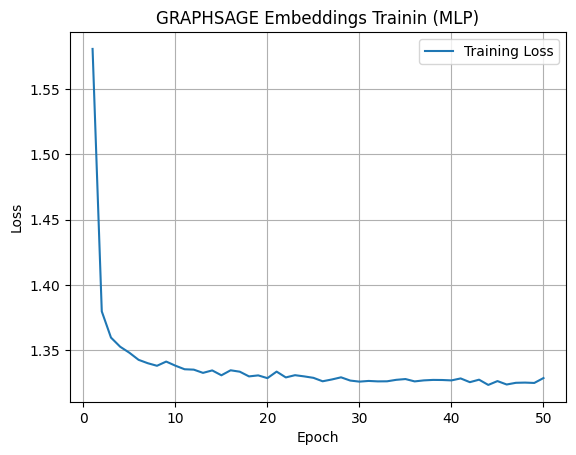

Accuracy: 95.9349593495935%
{'Electronic': [62182, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 70509, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 58426, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 49213, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 37141, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 95983, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 42442, ['Electronic', 'Electronic', 'Electronic', 'Electronic'

In [79]:
emb_scaled = StandardScaler().fit_transform(sage_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)

print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

sage_train_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for emb_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(emb_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    sage_train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), sage_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRAPHSAGE Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('sage_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for emb_batch, labels_batch in test_loader:
        outputs = model(emb_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")

sage_embeddings_recommendations = {}

for k, v in songs_for_inference.items():
    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]
        row_id = intermediate_df.index.get_loc(random_id)
        if genre not in sage_embeddings_recommendations:
            sage_embeddings_recommendations[genre] = []

        dist_emb = np.sqrt(np.sum((sage_embeddings - sage_embeddings[row_id]) ** 2, axis=1))
        idx = np.argsort(dist_emb)

        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            curr_idx = intermediate_df.index[curr_idx]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        sage_embeddings_recommendations[genre].extend((random_id, recommendations))

print(sage_embeddings_recommendations)

for k, v in sage_embeddings_recommendations.items():
    print(k, v)

<class 'torch.Tensor'> torch.Size([6395, 30]) <class 'torch.Tensor'> torch.Size([1599, 30]) torch.Size([6395]) torch.Size([1599])
+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |    3840    |
|  fc1.bias  |    128     |
| fc2.weight |    4096    |
|  fc2.bias  |     32     |
| fc3.weight |    256     |
|  fc3.bias  |     8      |
+------------+------------+
Total Trainable Params: 8360
Epoch 1, Loss: 1.5054700556397438
Epoch 11, Loss: 1.2769895017147064
Epoch 21, Loss: 1.2757817816734314
Epoch 31, Loss: 1.2759457033872605
Epoch 41, Loss: 1.2750856390595435


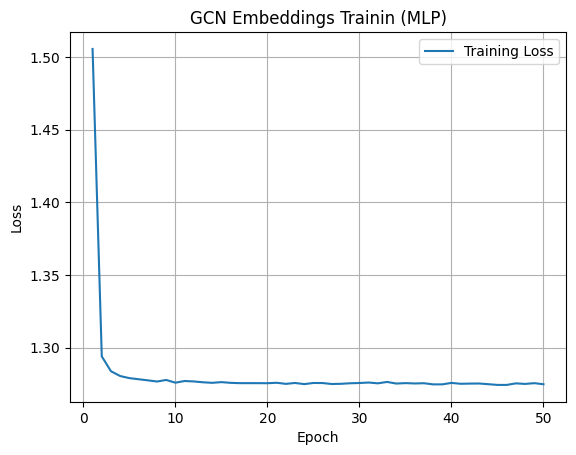

Accuracy: 100.0%
{'Electronic': [62182, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 70509, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 58426, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 49213, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 37141, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 95983, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electronic'], 42442, ['Electronic', 'Electronic', 'Electronic', 'Electronic', 'Electron

In [92]:
emb_scaled = StandardScaler().fit_transform(gcn_embeddings)
emb_tensor = torch.tensor(emb_scaled, dtype=torch.float32)

emb_train, emb_test, labels_train, labels_test = train_test_split(
    emb_tensor, labels_tensor, test_size=0.2, random_state=42
)

print(
    type(emb_train),
    emb_train.shape,
    type(emb_test),
    emb_test.shape,
    labels_train.shape,
    labels_test.shape,
)

train_dataset = TensorDataset(emb_train, labels_train)
test_dataset = TensorDataset(emb_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

model = SimpleMLP(n_in=emb_tensor.shape[1], n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)
gcn_train_losses = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for emb_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(emb_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    gcn_train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

plt.plot(range(1, num_epochs + 1), gcn_train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Embeddings Trainin (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('gcn_embedings_training_loss_curve.png')
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for emb_batch, labels_batch in test_loader:
        outputs = model(emb_batch)
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f"Accuracy: {100 * correct / total}%")

gcn_embeddings_recommendations = {}

for k, v in songs_for_inference.items():
    for random_id in v:
        song = intermediate_df["file_path_5s"][random_id]
        genre = intermediate_df["genre_top"][random_id]
        row_id = intermediate_df.index.get_loc(random_id)
        if genre not in gcn_embeddings_recommendations:
            gcn_embeddings_recommendations[genre] = []

        dist_emb = np.sqrt(np.sum((gcn_embeddings - gcn_embeddings[row_id]) ** 2, axis=1))
        idx = np.argsort(dist_emb)
        recommendations = []
        for i in range(10):
            curr_idx = idx[i + 1]
            curr_idx = intermediate_df.index[curr_idx]
            recommended_song = intermediate_df["file_path_5s"][curr_idx]
            recommended_genre = intermediate_df["genre_top"][curr_idx]
            recommendations.append(recommended_genre)

        gcn_embeddings_recommendations[genre].extend((random_id, recommendations))

print(gcn_embeddings_recommendations)

for k, v in gcn_embeddings_recommendations.items():
    print(k, v)

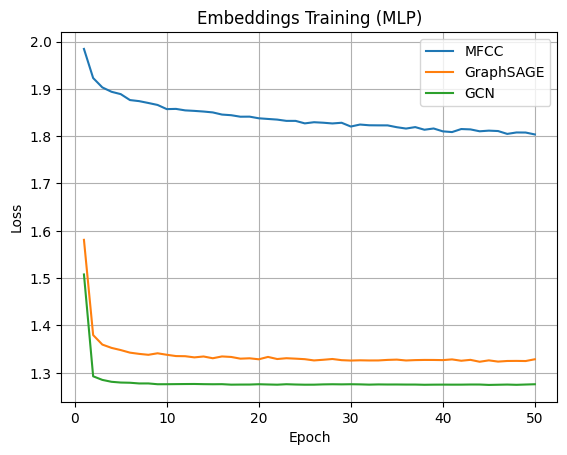

In [82]:
# make a single plot for all the losses
plt.plot(range(1, num_epochs + 1), mfcc_train_losses, label='MFCC')
plt.plot(range(1, num_epochs + 1), sage_train_losses, label='GraphSAGE')
plt.plot(range(1, num_epochs + 1), gcn_train_losses, label='GCN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Embeddings Training (MLP)')
plt.legend()
plt.grid(True)
plt.savefig('embedings_training_loss_curve.png')
plt.show()


In [83]:
all_recommendations = {
    'mfcc_rec': mfcc_embeddings_recommendations,
    'sage_rec': sage_embeddings_recommendations,
    'gcn_rec': gcn_embeddings_recommendations,
}

In [84]:
master_dict = {}
for k, v in all_recommendations.items():
    master_dict[k] = {}
    for genre, rec in v.items():
        for_inf, recommendations = [], []
        for i, r in enumerate(rec):
            if i % 2 == 0:
                for_inf.append(r)
            else:
                recommendations.append(r)
        master_dict[k][genre] = recommendations

print(master_dict.keys())

dict_keys(['mfcc_rec', 'sage_rec', 'gcn_rec'])


In [85]:
accuracy_scores = {}
for k, v in master_dict.items():
    accuracy_scores[k] = {}
    for i, j in v.items():
        accuracy_scores[k][i] = []
        for n in j:
            count_of_genres = n.count(i)
            accuracy_scores[k][i].append(count_of_genres / 10)

print(len(accuracy_scores))

3


In [86]:
final_dict = {}

for emb, rec in accuracy_scores.items():
    final_dict[emb] = {}
    for genre, acc in rec.items():
        final_dict[emb][genre] = round(np.mean(acc) * 100, 3)


In [87]:
# calculate the mean accuracy for each genre and each embedding type
mean_accuracy = {}
for emb, rec in accuracy_scores.items():
    mean_accuracy[emb] = round(np.mean([np.mean(v) for k, v in rec.items()]) * 100, 3)
print(mean_accuracy)

{'mfcc_rec': 29.063, 'sage_rec': 94.125, 'gcn_rec': 100.0}


In [90]:
final_df = pd.DataFrame(final_dict)
# add the mean accuracy to the final dataframe
final_df.loc['Avg. Accuracy'] = mean_accuracy
print(final_df)
final_df.to_csv('recommendations.csv', index=True)

               mfcc_rec  sage_rec  gcn_rec
Electronic       28.000   100.000    100.0
Experimental     17.600    99.700    100.0
Folk             30.400    96.400    100.0
Hip-Hop          29.200   100.000    100.0
Instrumental     29.300    69.100    100.0
International    33.800   100.000    100.0
Pop              18.200    88.400    100.0
Rock             46.000    99.400    100.0
Avg. Accuracy    29.063    94.125    100.0


In [91]:
print(final_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

\begin{tabular}{lrrr}
\toprule
 & mfcc_rec & sage_rec & gcn_rec \\
\midrule
Electronic & 28.00 & 100.00 & 100.00 \\
Experimental & 17.60 & 99.70 & 100.00 \\
Folk & 30.40 & 96.40 & 100.00 \\
Hip-Hop & 29.20 & 100.00 & 100.00 \\
Instrumental & 29.30 & 69.10 & 100.00 \\
International & 33.80 & 100.00 & 100.00 \\
Pop & 18.20 & 88.40 & 100.00 \\
Rock & 46.00 & 99.40 & 100.00 \\
Avg. Accuracy & 29.06 & 94.12 & 100.00 \\
\bottomrule
\end{tabular}



In [98]:
for random_id in songs_for_inference['Pop']:
    song = intermediate_df["file_path_5s"][random_id]
    song_name = os.path.basename(song)
    song_path = os.path.join(dir_path, 'fma_small_5s', song_name)
    genre = intermediate_df["genre_top"][random_id]

    if genre not in gcn_embeddings_recommendations:
        gcn_embeddings_recommendations[genre] = []
    row_id = intermediate_df.index.get_loc(random_id)
    dist_emb = np.sqrt(np.sum((gcn_embeddings - gcn_embeddings[row_id]) ** 2, axis=1))
    idx = np.argsort(dist_emb)
    x, fs = librosa.load(song_path, sr=44100)
    ipd.display(ipd.Audio(data=x, rate=fs))

    for i in range(7):
        curr_idx = idx[i + 1]
        curr_idx = intermediate_df.index[curr_idx]
        rec_genre = intermediate_df["genre_top"][curr_idx]
        rec_song = intermediate_df["file_path_5s"][curr_idx]
        rec_song_name = os.path.basename(intermediate_df["file_path_5s"][curr_idx])
        rec_song_path = os.path.join(dir_path, 'fma_small_5s', rec_song_name)
        print(f"File: {rec_song} - Music Genre: {rec_genre}")
        x, fs = librosa.load(rec_song_path, sr=44100)
        ipd.display(ipd.Audio(data=x, rate=fs))
    break


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085421.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085419.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085422.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085311.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085423.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085310.mp3 - Music Genre: Pop


File: /home/ics/Documents/Education/Media_engg/Sem_1/CASM/Project/fma_small_dataset/fma_small_5s/085424.mp3 - Music Genre: Pop


In [99]:
# ## Helper Functions

# def calculate_cosine_similarity(embeddings, random_id):
#     embeddings = np.array(embeddings)
#     reference_embedding = embeddings[random_id]
#     dot_product = np.dot(embeddings, reference_embedding)
#     norms = np.linalg.norm(embeddings, axis=1)
#     reference_norm = np.linalg.norm(reference_embedding)
#     cosine_similarity = dot_product / (norms * reference_norm)
#     return cosine_similarity


# def calculate_euclidean_distance(embeddings, random_id):
#     embeddings = np.array(embeddings)
#     distances = np.sqrt(np.sum((embeddings - embeddings[random_id]) ** 2, axis=1))
#     return distances


# def calculate_manhattan_distance(embeddings, random_id):
#     reference_embedding = embeddings[random_id]
#     manhattan_distance = np.sum(np.abs(embeddings - reference_embedding), axis=1)
#     return manhattan_distance


# def calculate_chebyshev_distance(embeddings, random_id):
#     reference_embedding = embeddings[random_id]
#     chebyshev_distance = np.max(np.abs(embeddings - reference_embedding), axis=1)
#     return chebyshev_distance


# def calculate_minkowski_distance(embeddings, random_id, p):
#     reference_embedding = embeddings[random_id]
#     minkowski_distance = np.sum(
#         np.abs(embeddings - reference_embedding) ** p, axis=1
#     ) ** (1 / p)
#     return minkowski_distance


# def calculate_hamming_distance(embeddings, random_id):
#     reference_embedding = embeddings[random_id]
#     hamming_distance = np.sum(embeddings != reference_embedding, axis=1)
#     return hamming_distance


# def calculate_jaccard_distance(embeddings, random_id):
#     reference_embedding = embeddings[random_id]
#     intersection = np.sum(np.minimum(embeddings, reference_embedding), axis=1)
#     union = np.sum(np.maximum(embeddings, reference_embedding), axis=1)
#     jaccard_distance = np.abs(1 - intersection / union)
#     return jaccard_distance